In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import os
import time
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [58]:
def aspect_ratio_preserving_resize(image, target_size):
    width, height = image.size
    target_width, target_height = target_size

    # Calculate the aspect ratio
    aspect_ratio = width / height

    if width > height:
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(new_height * aspect_ratio)

    # Perform the resize
    image = transforms.functional.resize(image, (new_height, new_width))

    # Create a new image with the target size and paste the resized image in the center
    new_image = Image.new("L", target_size)
    new_image.paste(image, ((target_width - new_width) // 2, (target_height - new_height) // 2))

    return new_image


class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        # Apply aspect ratio-preserving resize
        resized_image = aspect_ratio_preserving_resize(image, (100, 100))

        if self.transform:
            transformed_image = self.transform(resized_image)
        else:
            transformed_image = resized_image

        return transformed_image

In [59]:
# Define your data transformation
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=(5, 15)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])


test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])


In [60]:
batch_size = 16

# Load data
train_dataset = MyDataset(data_dir='/content/drive/MyDrive/AE_xray/train', transform=test_transform)
test_dataset = MyDataset(data_dir='/content/drive/MyDrive/AE_xray/test', transform=test_transform)
train_data, valid_data = train_test_split(train_dataset, test_size=0.1, random_state=42)

# Dataloader
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [61]:
class Encoder(nn.Module):
  def __init__(self , input_size = 10000 , hidden_size1 = 5000, hidden_size2 = 2000 , hidden_size3 = 1000, hidden_size4 = 500, z_dim = 200):
    super().__init__()
    self.fc1 = nn.Linear(input_size , hidden_size1)
    self.fc2 = nn.Linear(hidden_size1 , hidden_size2)
    self.fc3 = nn.Linear(hidden_size2 , hidden_size3)
    self.fc4 = nn.Linear(hidden_size3 , hidden_size4)
    self.fc5 = nn.Linear(hidden_size4 , z_dim)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    x = self.fc5(x)
    return x


In [62]:
class Decoder(nn.Module):
  def __init__(self , output_size = 10000 , hidden_size1 = 5000, hidden_size2 = 2000 , hidden_size3 = 1000, hidden_size4 = 500, z_dim = 200):
    super().__init__()
    self.fc1 = nn.Linear(z_dim , hidden_size4)
    self.fc2 = nn.Linear(hidden_size4 , hidden_size3)
    self.fc3 = nn.Linear(hidden_size3 , hidden_size2)
    self.fc4 = nn.Linear(hidden_size2 , hidden_size1)
    self.fc5 = nn.Linear(hidden_size1 , output_size)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    x = torch.sigmoid(self.fc5(x))
    return x

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [64]:
enc = Encoder().to(device)
dec = Decoder().to(device)

In [65]:
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())


In [71]:
train_loss = []
val_loss = []
num_epochs = 200
checkpoint_path = "/content/drive/MyDrive/model/Autoencoder/z200_val_xray_checkpoint_30z_5h_200e.pth"

In [72]:
# Check if a checkpoint exists to resume training
if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path)
  enc.load_state_dict(checkpoint["enc_state_dict"])
  dec.load_state_dict(checkpoint["dec_state_dict"])
  optimizer_enc.load_state_dict(checkpoint["optimizer_enc_state_dict"])
  optimizer_dec.load_state_dict(checkpoint["optimizer_dec_state_dict"])
  train_loss = checkpoint["train_loss"]
  val_loss = checkpoint["val_loss"]
  start_epoch = checkpoint["epoch"] + 1  # Start from the next epoch after the loaded checkpoint
  print("Resume training from epoch", start_epoch)
else:
  start_epoch = 1

Resume training from epoch 151


In [73]:
total_batches_train = len(train_dl)
total_batches_valid = len(valid_dl)
for epoch in range(start_epoch,num_epochs+1):
    train_epoch_loss = 0
    valid_epoch_loss = 0
    start_time = time.time()
    # Create a tqdm progress bar for the epoch
    epoch_progress = tqdm(enumerate(train_dl, 1), total=total_batches_train, desc=f'Epoch {epoch}/{num_epochs}', leave=False)
    for step, imgs in epoch_progress:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        latents = enc(imgs)
        output = dec(latents)
        loss = loss_fn(output, imgs)
        train_epoch_loss += loss.item()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()

    with torch.no_grad():
      for val_imgs in valid_dl:
        val_imgs = val_imgs.to(device)
        # val_imgs = add_noise(val_imgs)
        val_imgs = val_imgs.flatten(1)
        val_reconstructed = dec(enc(val_imgs))
        step_loss = loss_fn(val_reconstructed, val_imgs)
        valid_epoch_loss += step_loss.item()

    # epoch_progress.set_description(f'Epoch {epoch}/{num_epochs}, Step {step}/{total_batches}, Train_step_loss: {loss.item():.4f}, Val_step_loss: {step_loss.item():.4f}')
    # Calculate average loss
    train_epoch_loss /= total_batches_train
    valid_epoch_loss /= total_batches_valid

    train_loss.append(train_epoch_loss)
    val_loss.append(valid_epoch_loss)
    # Close the tqdm progress bar for the epoch
    epoch_progress.close()

    # Print the epoch loss after each epoch
    print('\n')
    print(f'Epoch {epoch}/{num_epochs}, Train_loss: {train_epoch_loss:.4f}, Val_loss: {valid_epoch_loss:.4f}, Time taken: [{time.time() - start_time:.2f}s]')

    # Save the model checkpoint along with training-related information
    checkpoint = {
        'epoch': epoch,
        'enc_state_dict': enc.state_dict(),
        'dec_state_dict':dec.state_dict(),
        'optimizer_enc_state_dict': optimizer_enc.state_dict(),
        'optimizer_dec_state_dict': optimizer_dec.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, checkpoint_path)




Epoch 151/200, Train_loss: 0.0113, Val_loss: 0.0133, Time taken: [3.89s]




Epoch 152/200, Train_loss: 0.0113, Val_loss: 0.0134, Time taken: [3.89s]




Epoch 153/200, Train_loss: 0.0112, Val_loss: 0.0134, Time taken: [3.89s]




Epoch 154/200, Train_loss: 0.0114, Val_loss: 0.0147, Time taken: [3.89s]




Epoch 155/200, Train_loss: 0.0116, Val_loss: 0.0135, Time taken: [3.89s]




Epoch 156/200, Train_loss: 0.0114, Val_loss: 0.0135, Time taken: [3.89s]




Epoch 157/200, Train_loss: 0.0112, Val_loss: 0.0135, Time taken: [3.89s]




Epoch 158/200, Train_loss: 0.0111, Val_loss: 0.0138, Time taken: [3.90s]




Epoch 159/200, Train_loss: 0.0111, Val_loss: 0.0138, Time taken: [3.90s]




Epoch 160/200, Train_loss: 0.0112, Val_loss: 0.0143, Time taken: [3.90s]




Epoch 161/200, Train_loss: 0.0118, Val_loss: 0.0137, Time taken: [3.91s]




Epoch 162/200, Train_loss: 0.0114, Val_loss: 0.0134, Time taken: [3.89s]




Epoch 163/200, Train_loss: 0.0113, Val_loss: 0.0136, Time taken: [3.89s]




Epoch 164/200, Train_loss: 0.0111, Val_loss: 0.0142, Time taken: [3.89s]




Epoch 165/200, Train_loss: 0.0114, Val_loss: 0.0142, Time taken: [3.90s]




Epoch 166/200, Train_loss: 0.0112, Val_loss: 0.0136, Time taken: [3.91s]




Epoch 167/200, Train_loss: 0.0111, Val_loss: 0.0143, Time taken: [3.89s]




Epoch 168/200, Train_loss: 0.0112, Val_loss: 0.0139, Time taken: [3.89s]




Epoch 169/200, Train_loss: 0.0110, Val_loss: 0.0135, Time taken: [3.88s]




Epoch 170/200, Train_loss: 0.0112, Val_loss: 0.0132, Time taken: [3.90s]




Epoch 171/200, Train_loss: 0.0110, Val_loss: 0.0134, Time taken: [3.89s]




Epoch 172/200, Train_loss: 0.0110, Val_loss: 0.0139, Time taken: [3.91s]




Epoch 173/200, Train_loss: 0.0108, Val_loss: 0.0137, Time taken: [3.90s]




Epoch 174/200, Train_loss: 0.0108, Val_loss: 0.0135, Time taken: [3.90s]




Epoch 175/200, Train_loss: 0.0111, Val_loss: 0.0136, Time taken: [3.89s]




Epoch 176/200, Train_loss: 0.0112, Val_loss: 0.0150, Time taken: [3.90s]




Epoch 177/200, Train_loss: 0.0113, Val_loss: 0.0141, Time taken: [3.90s]




Epoch 178/200, Train_loss: 0.0111, Val_loss: 0.0135, Time taken: [3.91s]




Epoch 179/200, Train_loss: 0.0109, Val_loss: 0.0135, Time taken: [3.90s]




Epoch 180/200, Train_loss: 0.0112, Val_loss: 0.0136, Time taken: [3.90s]




Epoch 181/200, Train_loss: 0.0108, Val_loss: 0.0134, Time taken: [3.90s]




Epoch 182/200, Train_loss: 0.0107, Val_loss: 0.0134, Time taken: [3.90s]




Epoch 183/200, Train_loss: 0.0105, Val_loss: 0.0136, Time taken: [3.91s]




Epoch 184/200, Train_loss: 0.0105, Val_loss: 0.0139, Time taken: [3.89s]




Epoch 185/200, Train_loss: 0.0105, Val_loss: 0.0137, Time taken: [3.89s]




Epoch 186/200, Train_loss: 0.0105, Val_loss: 0.0142, Time taken: [3.92s]




Epoch 187/200, Train_loss: 0.0109, Val_loss: 0.0149, Time taken: [3.90s]




Epoch 188/200, Train_loss: 0.0113, Val_loss: 0.0138, Time taken: [3.90s]




Epoch 189/200, Train_loss: 0.0108, Val_loss: 0.0138, Time taken: [3.89s]




Epoch 190/200, Train_loss: 0.0107, Val_loss: 0.0149, Time taken: [3.89s]




Epoch 191/200, Train_loss: 0.0110, Val_loss: 0.0155, Time taken: [3.91s]




Epoch 192/200, Train_loss: 0.0110, Val_loss: 0.0137, Time taken: [3.89s]




Epoch 193/200, Train_loss: 0.0104, Val_loss: 0.0137, Time taken: [3.91s]




Epoch 194/200, Train_loss: 0.0104, Val_loss: 0.0139, Time taken: [3.90s]




Epoch 195/200, Train_loss: 0.0103, Val_loss: 0.0140, Time taken: [3.91s]




Epoch 196/200, Train_loss: 0.0103, Val_loss: 0.0139, Time taken: [3.91s]




Epoch 197/200, Train_loss: 0.0102, Val_loss: 0.0138, Time taken: [3.91s]




Epoch 198/200, Train_loss: 0.0106, Val_loss: 0.0140, Time taken: [3.91s]




Epoch 199/200, Train_loss: 0.0105, Val_loss: 0.0140, Time taken: [3.93s]




Epoch 200/200, Train_loss: 0.0111, Val_loss: 0.0143, Time taken: [3.94s]


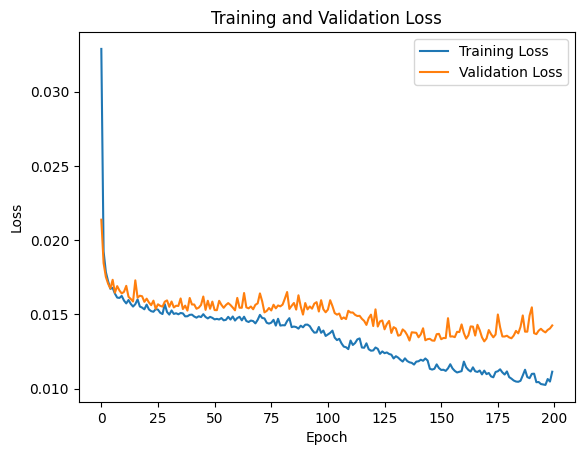

In [74]:
# checkpoint = torch.load(checkpoint_path)
train_loss = checkpoint['train_loss']
valid_loss = checkpoint['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

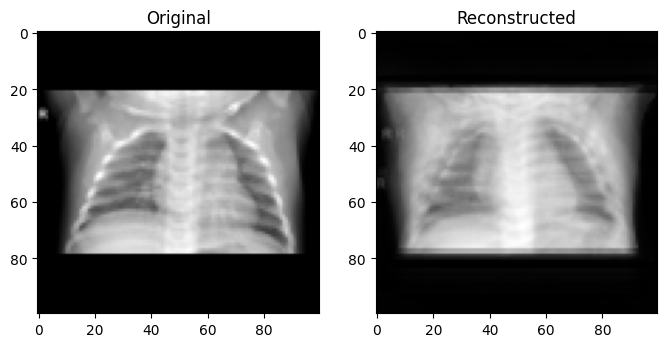

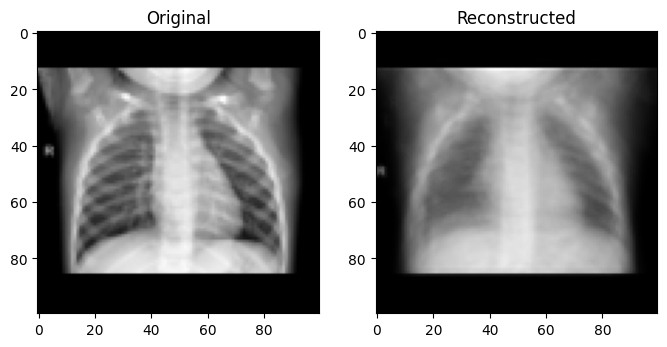

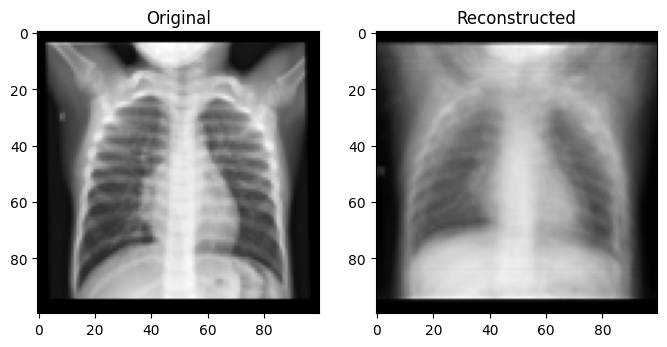

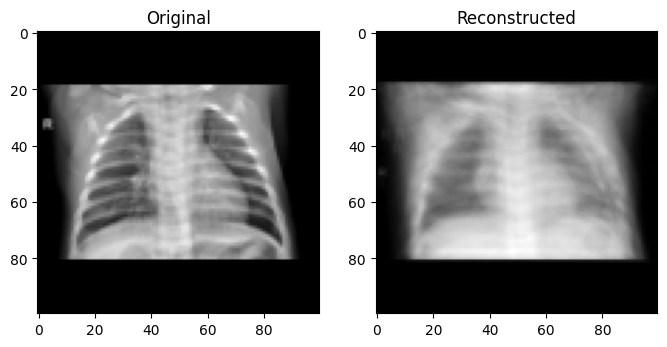

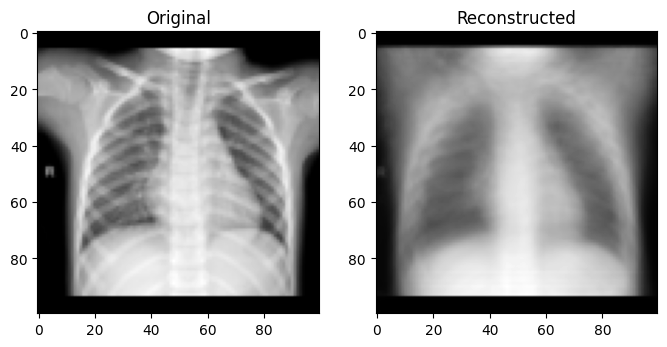

In [75]:
# Plot some original and reconstructed images
n_samples = 5  # Number of samples to visualize

with torch.no_grad():
    for i, batch in enumerate(test_dl):
        if i >= n_samples:
            break
        batch = batch.to(device)
        batch = batch.flatten(1)
        reconstructed = dec(enc(batch))

        original_image = batch[0].view(100,-1).cpu().numpy()
        reconstructed_image = reconstructed[0].view(100,-1).cpu().numpy()

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title('Original')
        plt.imshow(original_image, cmap='gray')  # Convert to grayscale for display

        plt.subplot(1, 2, 2)
        plt.title('Reconstructed')
        plt.imshow(reconstructed_image, cmap='gray')  # Convert to grayscale for display

        plt.show()
